https://adventofcode.com/2022/day/22

In [1]:
from dataclasses import dataclass, field
from typing import Optional, Self
import numpy as np
import re

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from time import sleep

def xy_array_as_string(array,
                       mapping: dict[int, str],
                       hspace: Optional[bool]=False):
    string_array = np.empty_like(array, dtype=str)
    for i, row in enumerate(array):
        for j, n in enumerate(row):
            string_array[i, j] = mapping.get(n)
    hjoin = ' ' if hspace else ''
    return '\n'.join([hjoin.join(row) for row in string_array.T])

@dataclass
class Board():
    board: np.ndarray
    loc: Optional[np.ndarray]=None
    direction: Optional[np.ndarray]=None
    edge_mappings: dict[tuple, dict[tuple, tuple]]=field(init=False)
    visited: set=field(init=False)
        
    def __post_init__(self):
        if not self.loc:
            self.loc = np.array([np.where(self.board[:,0] == 0)[0].min(), 0])
        if not self.direction:
            self.direction = np.array([1,0])
        self.edge_mappings = self.get_edge_mappings()
        self.visited = set()
        self.visited.add(tuple(self.loc))
            
    @property
    def state(self) -> np.ndarray:
        state_array = self.board.copy()
        marker = {(1,0): 3, # right
                  (0,-1): 4, # up
                  (-1,0): 5, # left
                  (0,1): 6} # down
        state_array[tuple(self.loc)] = marker[tuple(self.direction)]
        return state_array
        
    def __str__(self) -> str:
        return xy_array_as_string(self.state,
                                  mapping={0: '.', 1: ' ', 2:'#', 3:'>', 4:'^', 5:'<', 6:'V'},
                                  hspace=True)
    
    def turn(self,
             lr: str) -> None:
        right = np.array([[0, -1],
                         [1,  0]])
        left = np.array([[0,  1],
                          [-1, 0]])
        match lr:
            case 'L':
                self.direction = np.matmul(left, self.direction)
            case 'R':
                self.direction = np.matmul(right, self.direction)
                
    def move(self, n): # pre-calculate the next point on the board, including wrapping / boundary conditions.
        while n:
            n -= 1
            next_pos = self.loc + self.direction
            if ((next_pos[0] < 0) or
                (next_pos[1] < 0) or
                (next_pos[0] == self.board.shape[0]) or
                (next_pos[1] == self.board.shape[1]) or
                (self.board[tuple(next_pos)] == 1)):
                next_pos = self.edge_mappings[tuple(self.direction)].get(tuple(self.loc))
            if self.board[tuple(next_pos)] == 0:
                self.loc = next_pos
            self.visited.add(tuple(self.loc))
        
    def get_edge_mappings(self):
        """Map between sites connected across edges (boundaries)"""
        # get a list of all "edge" sites
        edge_mappings = {(1,0): {},
                         (0,1): {},
                         (-1,0): {},
                         (0,-1): {}}
        for x, row in enumerate(self.board.T):
            sites = np.hstack([np.where(row == 0)[0], np.where(row == 2)[0]])
            edge_mappings[(1, 0)][(max(sites), x)] = (min(sites), x)
            edge_mappings[(-1, 0)][(min(sites), x)] = (max(sites), x)
        for y, column in enumerate(self.board):
            sites = np.hstack([np.where(column == 0)[0], np.where(column == 2)[0]])
            edge_mappings[(0,1)][(y, max(sites))] = (y, min(sites))
            edge_mappings[(0,-1)][(y, min(sites))] = (y, max(sites))
        return edge_mappings
    
    @property
    def password(self) -> int:
        row = b.loc[1]+1
        column = b.loc[0]+1
        facing_mapping = {(1,0): 0,
                          (0,1): 0,
                          (-1,0): 2,
                          (0,-1): 3}
        facing = facing_mapping[tuple(b.direction)]
        return 1000*row + 4*column + facing
    
    @classmethod
    def from_data(cls,
                  data: list[str]) -> Self:
        width = max([len(line) for line in data])
        [line.ljust(width) for line in data]
        nboard = np.ones((width, len(data)))
        for y, line in enumerate(data):
            for x, s in enumerate(line):
                if s == '.':
                    nboard[x, y] = 0
                if s == '#':
                    nboard[x, y] = 2
        return Board(nboard)
    
    def display(self) -> None:
            clear_output(wait=True)
            to_plot = b.state
            to_plot[np.where(to_plot > 2)]=3
            for v in b.visited:
                to_plot[v] = 3
            to_plot[tuple(b.loc)] = 4
            plt.figure(figsize=(6,8))
            plt.matshow(to_plot.T, fignum=1)
            plt.axis('off')
            plt.show()
            sleep(0.01)
            
    def run(self,
            instructions: str,
            display=False) -> None:
        for i in next_instruction(instructions):
            match i[0]:
                case 'move':
                    self.move(i[1])
                case 'turn':
                    self.turn(i[1])
            if display and (i[0] == 'move'):
                self.display()

def next_instruction(instructions):
    while instructions:
        if i := re.match("^(\d+)", instructions):
            yield ("move", int(i[0]))
        elif i := re.match("^([LR])", instructions):
            yield ("turn", i[0])
        instructions = instructions[i.span()[1]:]

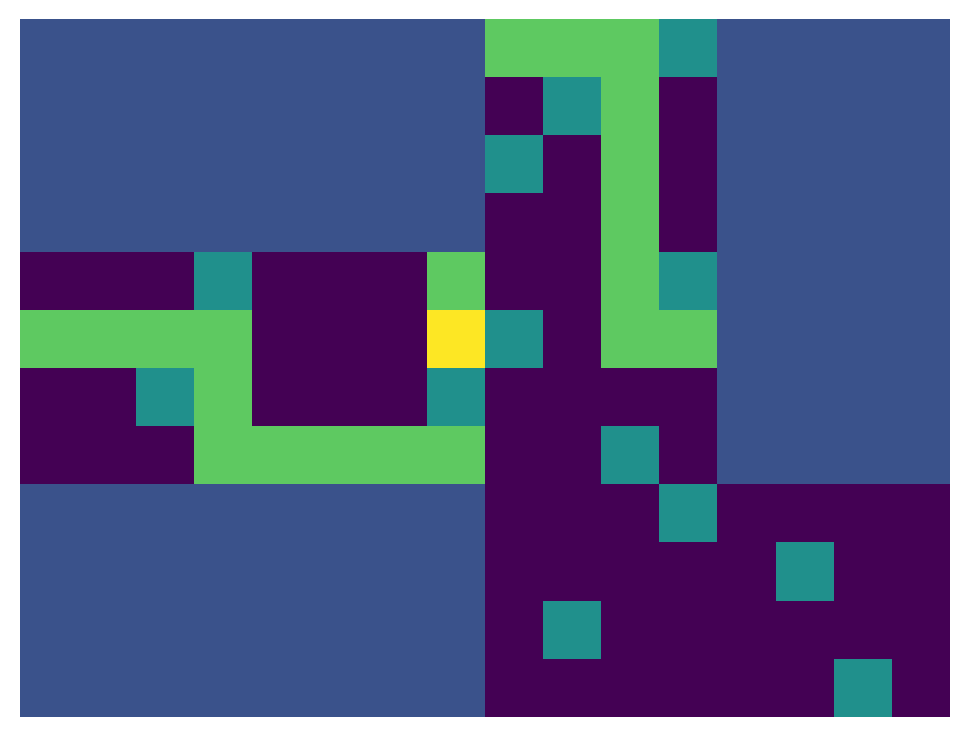

6032


In [13]:
filename = '../example_data/day22_example_data.txt'
with open(filename, 'r') as f:
    data = f.read().split('\n')
board_data = data[:-2]
instructions = data[-1]
b = Board.from_data(board_data)
b.run(instructions, display=True)
print(b.password)

In [10]:
filename = '../data/day22_data.txt'
with open(filename, 'r') as f:
    data = f.read().split('\n')
board_data = data[:-2]
instructions = data[-1]
b = Board.from_data(board_data)
b.run(instructions, display=True)
print(b.password)

KeyboardInterrupt: 

In [12]:
# finding all the edges and classifying them
from scipy.signal import convolve

w = np.ones((3,3), dtype=int)
w[1,1] = 0

convolve(b.board)

In [79]:
board_shape = b.board.copy()
board_shape[np.where(board_shape == 2)] = 0
board_shape = np.logical_not(board_shape).astype(int)
c_board_shape = convolve(board_shape, w, mode='same') * board_shape
edge_assignments = {3: 'convex',
                    5: 'straight',
                    6: 'straight',
                    7: 'concave'}
edges = {}
for k, v in edge_assignments.items():
    edges[v] = list(map(tuple, np.vstack(np.where(c_board_shape == k)).T))
edges['all'] = list(map(tuple, np.vstack(edges.values())))


# board_shape

/var/folders/np/pvnqvv3958gfjdtbgbbpjqk00000gn/T/ipykernel_30342/2735150775.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  edges['all'] = list(map(tuple, np.vstack(edges.values())))


In [78]:
list(map(tuple, np.vstack(edges.values())))

/var/folders/np/pvnqvv3958gfjdtbgbbpjqk00000gn/T/ipykernel_30342/1194700331.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  list(map(tuple, np.vstack(edges.values())))


[(0, 4),
 (0, 7),
 (8, 0),
 (8, 11),
 (11, 0),
 (15, 8),
 (15, 11),
 (7, 4),
 (7, 7),
 (8, 3),
 (8, 8),
 (11, 7),
 (12, 8),
 (8, 4),
 (8, 7),
 (11, 8)]

In [80]:
edges

{'convex': [(0, 4), (0, 7), (8, 0), (8, 11), (11, 0), (15, 8), (15, 11)],
 'straight': [(7, 4), (7, 7), (8, 3), (8, 8), (11, 7), (12, 8)],
 'concave': [(8, 4), (8, 7), (11, 8)],
 'all': [(0, 4),
  (0, 7),
  (8, 0),
  (8, 11),
  (11, 0),
  (15, 8),
  (15, 11),
  (7, 4),
  (7, 7),
  (8, 3),
  (8, 8),
  (11, 7),
  (12, 8),
  (8, 4),
  (8, 7),
  (11, 8)]}

In [117]:
# start from a concave position
loc = edges['concave'][0]
loc

(8, 4)

In [129]:
# start zipping neighbours, until we reach a corner.
zipping = True
loc_neighbours = edge_neighbours(loc, edges['all'])
print(loc_neighbours)
print([edge_type(e, edges) for e in loc_neighbours])
next_edges = [next_edge(e, loc, edges) for e in loc_neighbours]
print(next_edges, [edge_type(e, edges) for e in loc_neighbours])


[(7, 4), (8, 3)]
['straight', 'straight']


IndexError: list index out of range

In [90]:
from itertools import permutations

In [98]:
np.vstack(np.where(w == 1)).T - [1,1]
    

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

In [128]:
def edge_neighbours(loc, edges):
    return [tuple(e) for e in np.array(loc) + np.vstack(np.where(w == 1)).T - [1,1] 
            if tuple(e) in edges]

def next_edge(loc, last_edge, edges):
    return [l for l in edge_neighbours(loc, edges)][0]

def edge_type(loc, edges):
    for k, v in edges.items():
        if loc in v:
            return k

In [115]:
edge_neighbours((8, 4), edges['all'])

[(7, 4), (8, 3)]